# Fragment Hotspot Maps API

This jupyter notebook demostrates the functionality available in the fragment-hotspot-maps API.


## 1. Calculation

### 1.1 Protein preparation

Let us first calculate a fragment hotspot map.

The calculation can be initiated from a `ccdc.protein.Protein` instance which should be prepared **before** calculation. 

This can be done using the **CSD Python API**.
1. remove non-structural waters
2. remove ligands
3. remove metal atoms
4. add hydrogens

In [1]:
from ccdc.protein import Protein
import os

def prepare_protein(fname):
    prot = Protein.from_file(fname)
    prot.remove_all_waters()
    for ligand in prot.ligands:
        prot.remove_ligand(ligand.identifier)
    prot.remove_all_metals()
    prot.add_hydrogens()
    
    return prot

cwd = os.getcwd()
protein = prepare_protein("./data/1hcl.pdb")

### 1.2 Run calculation

A run can be initiated using the `Hotspot().from_protein()` method. Several calculation settings can parsed:

|**Settings**  |**Default** |**Description** |
|:---|:---|:---|
|**charged_probes**|_(bool, default=True)_ |This predicts positive and negative charge interaction propensity using the following SuperStar probes: <br /><br />_Positive: "Charged NH Nitrogen"<br />Negative: "Carboxylate Oxygen"_ <br /><br />In addition, the molecular probes used for sampling have been modified to account for reduction in hydrophobicity at charged sites.|
|**probe_size**| _(int, default=7)_ |An experimental feature, the size and shape of the molecular probes can be altered.
|**buriedness_method** |_(str, default="Ghecom")_|Pocket detection method employed. Options: Ghecom(default) or LIGSITE.<br /><br /> _NB: Ghecom can only be executed on Linux._|
|**cavities**|_(_`ccdc.cavity.Cavity` _instance, default=None)_| If the cavity of interest is known prior to calculation, parsing a CCDC Cavity instance will run the HS algorithm on that cavity only.|
|**nprocesses**|_(int, default=None)_| Parallelisation settings.|
|**sampler_settings** |_(_`Hotspot._Sampler.Settings` _instance, default=None)_| Enables alteration of sampler settings.|

In [8]:
from hotspots.hotspot_calculation import Hotspots
from ccdc.cavity import Cavity

# cavity mode
h = Hotspots()
cavities = Cavity.from_pdb_file("./data/1hcl.pdb")

# settings altered for speed (demo purposes)
settings = h._Sampler().Settings()
settings.nrotations = 500
apolar_translation_threshold = 17
polar_translation_threshold = 17

result = h.from_protein(protein=protein,
                        charged_probes=False,
                        probe_size=7,
                        buriedness_method='ligsite',
                        cavities=cavities,
                        nprocesses=6,
                        sampler_settings = settings)


Start atomic hotspot detection
Atomic hotspot detection complete

Start buriedness calcualtion
    method: LIGSITE
Buriedness calcualtion complete

Start sampling

    nRotations: 500 nTranslations: 137 probename: donor


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.31it/s]



    nRotations: 500 nTranslations: 839 probename: apolar


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:45<00:00,  4.79it/s]



    nRotations: 500 nTranslations: 205 probename: acceptor


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 19.13it/s]


Sampling complete

Runtime = 283.36500001seconds


In [9]:
view = result.ngl_widget()
view

A Jupyter Widget

A Jupyter Widget

## 2. IO

The `fragment-hotspot-maps` package supports reading and writing to various formats, through the `fragment_hotspot_maps.io.HotspotReader` and `fragment_hotspot_maps.io.HotspotWriter` classes respectively.


### 2.1 io.HotspotWriter

Supported 3rd-party visualisation:

|**Visualiser**  |**Grid format** |**Description** |
|:---|:---|:---|
|**PyMol** |".grd", ".ccp4", ".acnt"| outputs a python script which can be run within pymol to automatically setup the results|
|**NGLView** |".ccp4"| outputs NGLWidget for visualisation in jupyter notebooks 

The grid files which contain the fragment hotspot scores are reasonably large and therefore results are zipped by default. This can be overidden by parsing zip_results=False in the HotspotWriter initalisation. 


In [11]:
from hotspots import hotspot_io

out = "Z:/github_packages/fragment_hotspot_maps/jupyter_notebook/data"
with hotspot_io.HotspotWriter(out, visualisation="pymol", grid_extension=".ccp4", zip_results=True) as writer:
     writer.write(result)

### 2.2 io.HotspotReader

The `fragment_hotspot_maps.io.HotspotReader` class facilities reading HotspotResults from either a directory or zipped directory. 

The read method returns a list of hotspots found in the input (zipped) directory.

In [14]:
from hotspots import hotspot_io
from os.path import join

hr = hotspot_io.HotspotReader(join(out, "out.zip")).read()

## 3. Analysis

### 3.1 Scoring

Scoring of the following objects is supported:

- `ccdc.protein.Protein` : stored in bfactor attribute
- `ccdc.cavity.Cavity` (TO DO)
- `ccdc.molecule.Molecule` : stored in partial charge attribute
- `fragment_hotspot_calculation.hotspot_calculation.Hotspot` : stored in score attribute 


In [16]:
from ccdc.io import MoleculeReader
import pandas as pd

molecule = MoleculeReader(join(out, "ligand.mol2"))[0]
scored_molecule = hr.score(molecule)

pd.DataFrame({"Atom Identifier":[a.label for a in scored_molecule.heavy_atoms], 
              "Fragment Hotspot Score":[a.partial_charge for a in scored_molecule.heavy_atoms]})


,Atom Identifier,Fragment Hotspot Score
0,C1,16.705568
1,C2,17.234985
2,C3,17.944593
3,C4,17.234985
4,C5,13.825326
5,C6,16.705568
6,N,14.471614
7,C9,16.846706
8,N2,18.118723


<IPython.core.display.Javascript object>


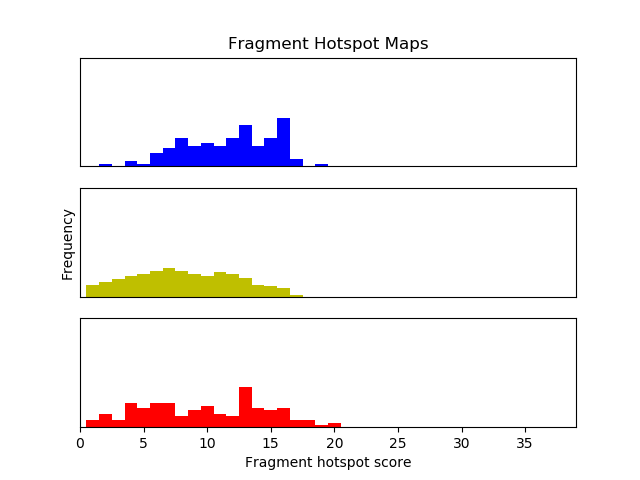

In [17]:
%matplotlib notebook

data, p = hr.get_histogram()

### 3.2 Fragment hotspot boundaries

The fragment hotspot calculation represents a fragment hotspot as a continum of scores denoting the likeihood of a hotspot at a given grid location. Score cutoffs were derived empirically from the scores of fragment atoms in known fragment hotspots:

- **"Strong hotspot"**: > 17
- **"Warm spot"**: 14 - 17
- **"Binding Unlikely"**: < 10

For application to small molecule design, it is useful infer the boundaries of hotspot regions to aid the prediction of multiple fragment hotspot in a single cavity and the derivation of pharmacophoric features.

Therefore, we have implemented a method which given a user-specified volume will output the highest scoring, connected region of the fragment hotspot map for that volume. This can be run in two modes:

1. "seed" - returns multiple detected hotspot for given volume
2. "global" - returns the top hotspot for given volume


In [20]:
from hotspots import hotspot_io
from hotspots import best_volume

extractor = best_volume.Extractor(hr, mode="seed", volume="100")

with hotspot_io.HotspotWriter(out,
                      visualisation="pymol",
                      grid_extension=".ccp4", 
                      zip_results=True) as writer:
    writer.write(extractor.extracted_hotspots)

Initialise Extractor
    Mode: 'seed'
Generate Single Grid
Extracting Hotspots
(100.5, 100.0, 79.5)
4.0
target = 800, actual = 1221
17.77114263515873
(92.0, 73.5, 67.5)
4.0
target = 800, actual = 1087
15.216794322780853
[17.94459342956543, 15.901166915893555]
rank 1 score 17.94459342956543
rank 2 score 15.901166915893555


In [24]:
from ipywidgets import VBox, Layout, HBox

# side by side extracted versus original
view1 = hr.ngl_widget()
view2 = extractor.extracted_hotspots[0].ngl_widget()
left = VBox([view1], layout=Layout(width='60%', height='80%'))
right = VBox([view2], layout=Layout(width='60%', height='80%'))

HBox([left, right])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## 4. Small Molecule Design

### 4.1 Pharmacophores

Pharmacophores can be generated from any HotspotResult object, but it is recommended to first extract a volume of interest so that the derived models are of the desired size. 

I/O of pharmacophore models is controlled through the `fragment_hotspot_map.pharmacophore.PharmacophoreModel` class.

|**Supported format**|**Read**|**Write**|**Usage** |
|:---|:---:|:---:|:---|
|**CrossMiner file** (.cm)|✅|✅|Can be imported directly into CSD-CrossMiner for search the PDB and CSD. <br/>NB: Charged interaction features are currently unsupported in CrossMiner |
|**Pymol python script** (.py) |❌|✅ |Can be run within PyMol and visualised using cgo objects |
|**JSON file** (.json) |❌|✅ |Can be imported directly into Pharmit, an open-source pharmacophore-based virtual screening engine|
|**Mol2 file** (.mol2) |❌|✅|Flexible usage |
|**CSV file** (.csv) |❌|✅ |Flexible usage |


In [26]:
from hotspots import hotspot_io

hr = hotspot_io.HotspotReader("./data/hotspot_boundaries.zip").read(identifier=0)[0]
pharmacophore = hr.get_pharmacophore_model(identifier="example")

pharmacophore.write(fname=join(out, "pharmacophore.cm"))


WARNING! Charged features not currently supported in CrossMiner!


### 4.2 Selectivity

An experimental feature being developed by *Mihaela Smilova*
<insert more info here> 

In [ ]:
# example code